## Black-Scholes-Merton model

* The nice thing about setting up external code bases in `.py` files is that you can easily import the code in a new notebook
* We'll now reload the `options.py` file containing the *Option* class definition into a new notebook/project

In [1]:
## Some preliminaries
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
os.chdir('g:/My Drive/teaching/1_boot camp python');

In [25]:
import options as opts ## imports the g:/My Drive/teaching/1_boot camp/options.py file
sigma,rf,TT,S0,KK = 0.15,0.02,1,30,35
opt = opts.Option(sigma,rf,TT,S0,KK) ## the class definition is inside opts
print(opt)

sigma:0.15  rf:0.02  TT (mat):1  S0:30  KK (strike):35



## The underlying stochastic process

* It can be shown that the limiting process modeled by the binmial tree is the geometric Brownian motion
$$
\Delta S(t+h) = \mu S(t) h + \sigma S(t) \epsilon(t+h)
$$
where $\epsilon(t+h) \sim N(0,h)$ (the variance is $h$)
* A common way of writing the above discrete-time process as $h \to 0$ is
$$
dS(t) = \mu S(t) dt + \sigma S(t) dW(t)
$$
* There is a lot of cool stuff that you can do with this representation once you learn stochatic calculus
* For example you can derive an exact option pricing formula (you'll see how soon)

## Black-Scholes-Merton

* The Black-Scholes-Merton model gives a closed form solution for the price of a European option
$$
C = N(d_1) S_0 - N(d_2) K e^{-rt}
$$
where $N(\cdot)$ is the standard normal cdf
* The put price is obtained using put-call parity, a no-arbitrage relationship between the stock price, the call and put prices, and the short-term interest rate
$$
P + S = C + Ke^{-rt}
$$
where $P$ and $C$ are the put and call prices of the same-strike, $t$-maturity options
* The formula assumes no early exercise and no dividends
* We'll examine put-call parity in a few minutes

In [3]:
import scipy.stats as stats
def price_european_option_bsm(sigma,rf,TT,S0,KK,kind):
    '''
    sigma, rr, TT, S0, KK -- the annual volatility, risk-free rate, maturity, stock price, strike
    kind -- 'call' or 'put'
    '''
    assert kind in ['call','put']
    
    d1 = (np.log(S0/KK) + (rf+sigma**2/2)*TT)/(sigma*np.sqrt(TT))
    d2 = d1 - sigma * np.sqrt(TT)
    call = stats.norm.cdf(d1)*S0 - stats.norm.cdf(d2)*KK*np.exp(-rf*TT)
    
    if kind == 'call':
        return call
    else:
        return call + KK*np.exp(-rf*TT) - S0

In [4]:
bspr = price_european_option_bsm(sigma,rf,TT,S0,KK,'call')
ss,pp = opt.price_european_option_with_tree(50,'call')
print(bspr,pp[0],bspr-pp[0][0])

0.4874900952556471 [0.4903088783432341] -0.0028187830875869846


Conveniently, you can redefine classes on the fly in Python
* Let's add the closed form method to our option class
* Pay attention to the role of the *self* argument $\leftarrow$ What is this?

In [5]:
## methods in classes take the argument 'self' to refer to the object in question
def price_european_option_bsm_wrapper(self,kind):
    return price_european_option_bsm(self.sigma,self.rf,self.TT,self.S0,self.KK,kind)

## once we add the new method to the class, all existing instances of the class have access to the method
opts.Option.price_european_option_bsm = price_european_option_bsm_wrapper
print(bspr,opt.price_european_option_bsm('call'))

0.4874900952556471 0.4874900952556471


* This is okay for teaching or for playing around with a class, but
* It is better to put the definition into the `g:/My Drive/teaching/1_boot camp python/options.py` file

## Put-call parity
* Recall that we claimed there is a no-arbitrage relationship called put-call parity
$$
P_0 + S_0 = C_0 + Ke^{-rt} \tag{$\dagger$}
$$
* Let's verify this programmatically using Pandas and *lambda* functions
    * Lambda functions are a convenient tool to define simple function on the fly
    * We'll be using some features of Pandas you may not be familiar with
    * It's okay -- look over the code after class to understand what's going on
* We want to check that the *future* values of the left and right-hand sides of $(\dagger)$ are always the same
    * This ensures that the relationship in ($\dagger$) -- which is in terms of _today's_ prices -- holds via no arbitrage

In [6]:
rf, TT, KK, S0 = 0.05, 3, 50, 60
C0 = KK*np.exp(-rf*TT)  ## starting cash alongside call
put_price = lambda stk: max(KK-stk,0)   ## i.e., buy at 'stk' and sell at 'KK'
call_price = lambda stk: max(stk-KK,0)  ## i.e., buy at 'KK' and sell at 'stk'
future_cash_value = lambda cash: cash * np.exp(rf * TT)

vals = []
for stk in range(30,70):
    vals.append({'Stk':stk,
                'Put':put_price(stk),
                'Call':call_price(stk),
                'Cash':future_cash_value(C0)})
vals = pd.DataFrame(vals) ## like a Series, but a DataFrame can store multiple columns
vals.set_index('Stk',inplace=True)  ## this tells the DataFrame to make the 'Stk' into its index
print(vals.iloc[19:23])  ## this is how you reference a DataFrame by numerical index
print(vals.loc[49:52])   ## this references by the actual index value (note it is *inclusive*)

     Put  Call  Cash
Stk                 
49     1     0  50.0
50     0     0  50.0
51     0     1  50.0
52     0     2  50.0
     Put  Call  Cash
Stk                 
49     1     0  50.0
50     0     0  50.0
51     0     1  50.0
52     0     2  50.0


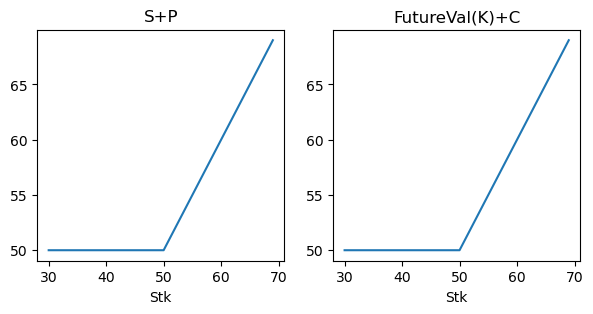

In [7]:
## Now let's check put call parity
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(7,3))
## Pandas automatically labels x-axis with the index values
(vals.index + vals.Put).plot(ax=axs[0],title='S+P')  ## stock price in index
(vals.Cash + vals.Call).plot(ax=axs[1],title='FutureVal(K)+C');

## Comparing binomial trees to the BSM model
* We have not yet explored the sensitivity of option prices to the parameters (vols, stock price, etc.)
    * We'll talk more about this soon
* For the moment, let's focus on one particular parameter of the model: the number of steps in the tree
* What happens to the option price as we increase the number of steps and therefore decrease the step size, which equals $T/N$
* Take a look at the paper: Leisen and Reimer, 1996, "Binomial models for option valuation -- examining and improving convergence" (thanks to Kaiwen Hou for reference)

In [8]:
callpr = {}
print()
for NN in range(30,1010,30):
    print(NN,end=' ')
    ss,pp=opt.price_european_option_with_tree(NN,'call')
    ## NOTE that pp is a dictionary of lists, with the first list having one element: the option price at time 0
    ## take the option prices from step 0 in the tree, and the 1st element of that array
    callpr[NN] = pp[0][0]
print()


30 60 90 120 150 180 210 240 270 300 330 360 390 420 450 480 510 540 570 600 630 660 690 720 750 780 810 840 870 900 930 960 990 


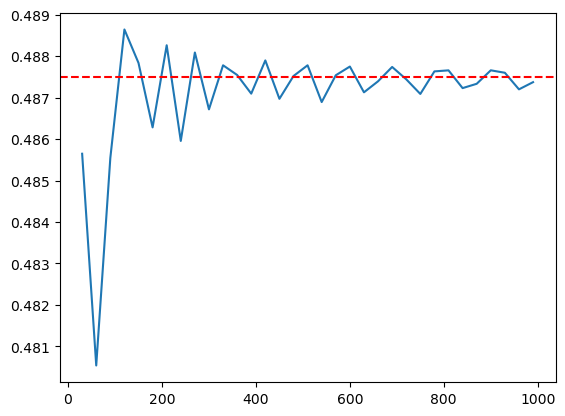

In [9]:
## convert to a Pandas series
callpr = pd.Series(callpr) ## convert to Pandas series for ease of plotting
ax=callpr.plot()
ax.axhline(bspr,color='red',linestyle='--')

Notice this code block in the *prices_and_rnprobs_at_step* method in `options.py`:
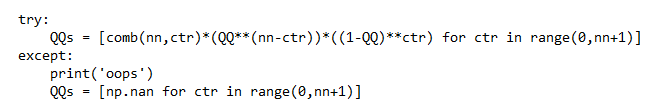

Why is the `try...except` code needed?
* Consider our risk-neutral probability calculation:
$$
\left( \begin{array}{c} N \\ K \end{array} \right) Q^{N-K} (1-Q)^K
$$
* What happens when $N$ and $K$ are very large?

In [10]:
from math import comb
QQ = 0.501
for NN in [1010,1030]:
    kk = int(NN/2)
    ans = comb(NN,kk)*QQ**(NN-kk)*(1-QQ)**kk
    print(ans)

0.025049242628127386


OverflowError: int too large to convert to float

* Note that we don't even use the risk-neutral probability vector in the binomial pricing.
* We only needed it as a robustness check and to plot the stock distribution.
* We either need fancier analytics that recognize that the probabilities that multiply the n choose k term drive the combination to be very low...
* Or we can tell the code to ignore errors.

In [11]:
from math import comb
QQ = 0.501
for NN in [1010,1030]:
    kk = int(NN/2)
    try:
        ans = comb(NN,kk)*QQ**(NN-kk)*(1-QQ)**kk
    except:
        ans = np.nan
    print(ans)

0.025049242628127386
nan


## Summarizing
* Binomial trees are intuitively easier to grasp
* The get arbitrarily close to the "correct" Black-Scholes-Merton price, but the rate of convergence is slow (and weird)
* Numerous methods have been proposed to accelerate the rate of convergence (e.g., https://link.springer.com/article/10.1007/s007800200094)
* There are other schemes, like *trinomial trees* (https://warwick.ac.uk/fac/sci/maths/people/staff/oleg_zaboronski/fm/trinomial_tree_2009.pdf)
* When working with numerical schemes (e.g., dynamic programming, binomial trees, simulations, etc.) you are never going to be the expert
* Find resources that discuss how to implement efficient numerical schemes (this is something applied mathematicians do for a living)
* It is very good practice to benchmark against a known solution (like our BSM benchmark) -- then the calibration that works well for this will (hopefully) for in cases where the exact solution is not known

## The greeks
* The main parameters that go into a European option price and the option price sensitivity to them:

| Parameter | Greek |
| --------- | ----- |
| Stock price | Delta |
| 2nd stock deriv | Gamma |
| Sigma | Vega | 
| $r_f$ | Rho |
| $T$ | Theta |
* Let's write a generic function to calculate
$$
\frac{dP}{d\xi}
$$
where $P$ is the option price and $\xi$ is the parameter of interest
* As a mini-hw exercise, check what happens to the code below when `eps = 1e-8`
    * Numerical analysis is an *art* and a science

In [24]:
def calc_opt_deriv(self,param,kind):
    '''
    param -- the name of the parameter who sensitivity we want
    '''
 
    p1 = self.price_european_option_bsm(kind=kind)
    orig = getattr(self,param)
    
    ## perturb
    eps = 1e-5  ## experiment with this
    setattr(self,param,getattr(self,param)+eps)
    p2 = self.price_european_option_bsm(kind=kind)
    
    ## and again
    setattr(self,param,getattr(self,param)+eps)
    p3 = self.price_european_option_bsm(kind=kind)
    
    ## restore original value
    setattr(self,param,orig)
    
    ## return first and second derivs
    return {'d1':(p2-p1)/eps, 'd2':(p3-2*p2+p1)/eps**2}

## update class
opts.Option.calc_opt_deriv = calc_opt_deriv

### Interpret the option delta and gamma

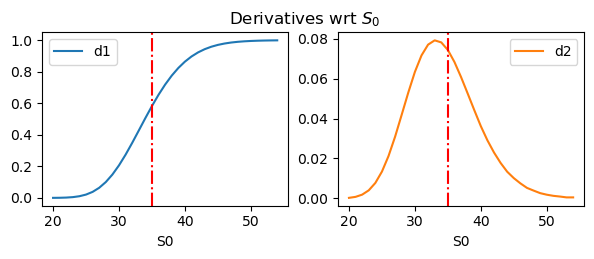

In [26]:
S0_save = opt.S0  ## make sure to restore the object state
S0s = range(20,55,1)
derivs = []
for S0 in S0s:
    opt.S0 = S0
    res = opt.calc_opt_deriv('S0','call')
    res['S0'] = S0
    derivs.append(res)
derivs = pd.DataFrame(derivs)
derivs.set_index('S0',inplace=True)
opt.S0 = S0_save  ## restore the orignal value
axs = derivs.plot(figsize=(7,2.25),title='Derivatives wrt $S_0$',subplots=True,layout=(1,2))
for ii in range(2): axs[0,ii].axvline(opt.KK,color='red',linestyle='-.');

* How do you interpret the above gamma plot?

Let's make the code above more general and calculate the other greeks

In [15]:
def show_greeks(self,param,kind):
    '''
    param -- which parameter to perturb (the x-axis is assumed to be S0, but this can
    be changed to reflect the variable being perturbed)
    kind -- 'call' or 'put'
    '''
    assert param in ['S0','KK','sigma','rf','TT']  ## sanity check
    S0_save = self.S0  ## make sure to restore the object state
    S0s = range(int(0.65*opt.KK),int(1.5*opt.KK),1) ## don't hard code range
    try: ## any time you modify object state, should be in a try call so it can be restored
        derivs = []
        for S0 in S0s:
            self.S0 = S0
            res = self.calc_opt_deriv(param,kind)
            res['S0'] = S0
            derivs.append(res)
        derivs = pd.DataFrame(derivs)
        derivs.set_index('S0',inplace=True)
    except:
        print('Oops')
    self.S0 = S0_save  ## restore the original value
    axs = derivs.plot(figsize=(8,3),title=f'Derivatives for {kind} wrt {param}',subplots=True,layout=(1,2))
    for ii in range(2):
        axs[0,ii].axvline(self.KK,color='red',linestyle='-.')

opts.Option.show_greeks = show_greeks ## extend class definition

sigma:0.15  rf:0.02  TT (mat):1  S0:30  KK (strike):35



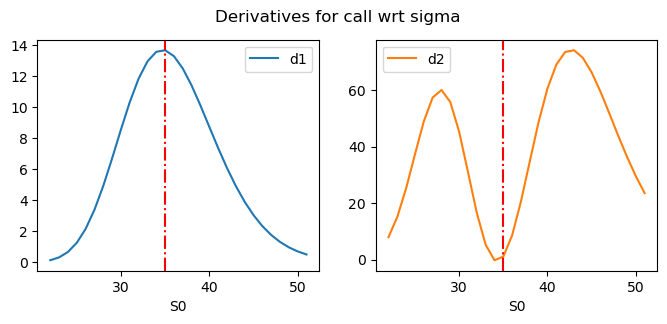

In [16]:
print(opt)
opt.show_greeks('sigma','call')

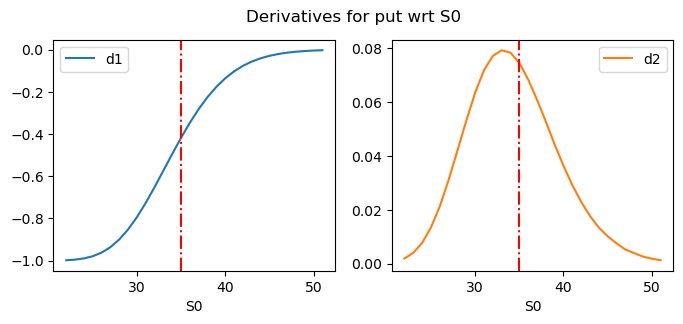

In [17]:
opt.show_greeks('S0','put')

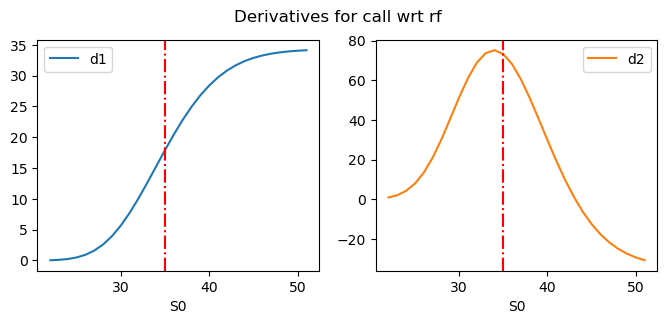

In [18]:
opt.show_greeks('rf','call')

## Simulations and delta hedging

* Our assumed stock price process is
$$
\Delta S(t+h) = \mu S(t) h + \sigma S(t) \epsilon(t+h)
$$
* Let's take this for a spin, along with our option pricing machinery
* Let's simulate one path of the above process every day for one year (so $h$ = one day) and see what the option price looks like
* Notice that thus far $\mu$ has not been used in any of our analysis!
* This is because when pricing under the risk-neutral measure, the stock's drift equals $r_f$
* But for running our simulations, we'll do them under the *physical measure* and use $\mu$
* But first, let's recall what the Option class we've constructed looks like

In [19]:
help(opts.Option)

Help on class Option in module options:

class Option(builtins.object)
 |  Option(sigma, rf, TT, S0, KK)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sigma, rf, TT, S0, KK)
 |      This is the constructor and self refers to the object instance. It must be the first argument
 |      passed into the constructor. The constructor is called with the information to create an Option
 |      object, and then the class provides operations to perform on this object.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  calc_opt_deriv(self, param, kind)
 |      param -- the name of the parameter who sensitivity we want
 |  
 |  get_Q(self, tau)
 |  
 |  plot_rn_price_dist_at_step(self, nn, NN)
 |  
 |  price_european_option_bsm = price_european_option_bsm_wrapper(self, kind)
 |      ## methods in classes take the argument 'self' to refer to the object in question
 |  
 |  price_european_option_with_tree(self, NN, kind)
 |      NN -- number of steps in the tree
 |      kind -- the 

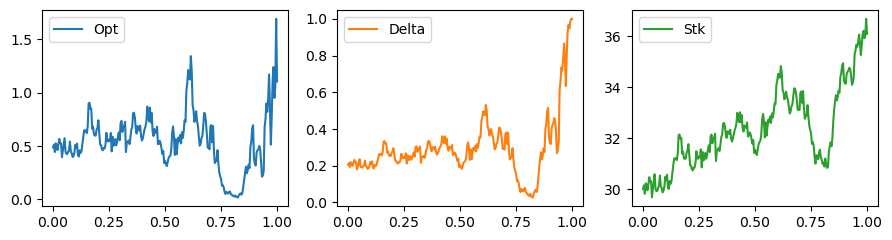

In [31]:
np.random.seed(1234) ## to make this reproducible
sigma, rf, TT, S0, KK, mu, hh = 0.15, 0.02, 1.0, 30, 35, 0.08, 1/252
times = np.arange(0,TT+hh,hh)
SS = pd.Series(0,index=times,name='Stk')
opt_vals = pd.DataFrame(0,index=times,columns=['Opt','Delta'])
for ii in range(0,len(times)):
    ## sqrt(hh) because np.random.normal expects a std dev
    if ii == 0:SS.iloc[0] = S0
    else: SS.iloc[ii] = SS.iloc[ii-1] + \
        SS.iloc[ii-1] * (mu * hh + sigma * np.random.normal(0,np.sqrt(hh)))
    ## at each point calculate (the max is to trick it to price 0 maturity option)
    opt = opts.Option(sigma,rf,max(TT-times[ii],1e-5),SS.iloc[ii],KK)
    opt_vals.loc[times[ii],'Opt'] = opt.price_european_option_bsm('call')
    derivs = opt.calc_opt_deriv('S0','call')
    opt_vals.loc[times[ii],'Delta'] = derivs['d1']
## merge the data
opt_vals = opt_vals.merge(SS,left_index=True,right_index=True)
opt_vals.plot(subplots=True,layout=(1,3),figsize=(9,2.5)); plt.tight_layout()

Cool fact: The delta gives us a rule for option replication!
* Remember, this is how we priced our one period option in the binomial tree: We solved for the $\Delta$ and the cash position in the replicating portfolio, and said that by no-arbitrage the option price should equal
$$
\text{Option price} = \Delta \times S + B
$$
* Let's check whether how works in our simulation
* Pretend you're an option market maker and you sold the payout of this option to a client, who paid you an option price $C_0$ (plus a little bit of markup)
* Let us refer to the value of the replicating portfolio as $V_t$ and then $V_0 = C_0$
* The initial positions in stock and cash are $\Delta_0$ and $B_0 = C_0 - \Delta_0 \times S_0$ (why?)
* The value of the replicating portfolio next period is (note $\exp(r_f h) \approx 1 + r_f h$ for small $h$)
$$
V_h = \Delta_0 \times S_h + B_0 \times (1+r_f h)
$$
* At this point, the delta is $\Delta_h$ and the cash position is $B_h = V_h - \Delta_h \times S_h$
* And we keep on going

You will need to think about this offline to really get it

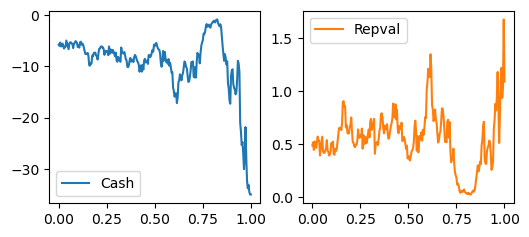

In [32]:
## Let's calculate the value of the replicating portfolio
rep_vals = pd.DataFrame(0,index=times,columns=['Cash','Repval'])
for ii in range(0,len(times)):
    if ii == 0:
        rep_vals.loc[times[ii],'Repval'] = opt_vals.loc[times[ii],'Opt']
    else: ## note the delta and cash position are from the prior day
        rep_vals.loc[times[ii],'Repval'] = opt_vals.loc[times[ii-1],'Delta'] \
            * opt_vals.loc[times[ii],'Stk'] + \
            rep_vals.loc[times[ii-1],'Cash'] * (1+rf*hh)
    
    ## get the cash position
    rep_vals.loc[times[ii],'Cash'] = rep_vals.loc[times[ii],'Repval'] - \
        opt_vals.loc[times[ii],'Delta'] * opt_vals.loc[times[ii],'Stk']
    
rep_vals.plot(subplots=True,layout=(1,2),figsize=(6,2.5))
opt_vals = opt_vals.merge(rep_vals,left_index=True,right_index=True) ## merge the two DataFrames

* Does it work? Let's see how the value of replicating portfolio and the option evolve over time.

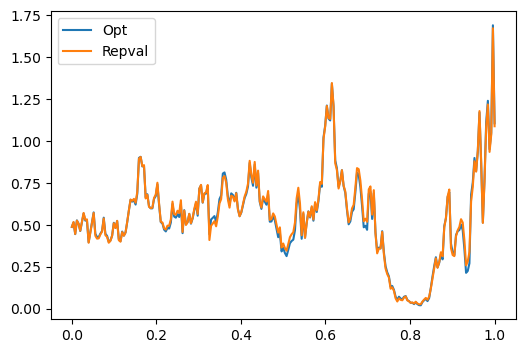

In [22]:
opt_vals[['Opt','Repval']].plot(figsize=(6,4));

* As $h\to 0$ the replicating portfolio becomes exact

## Summary
* We saw in a one period setting, we can replicate an option payout using a position in the stock and cash (and the probabilility of up or down moves did not matter)
* This idea generalized to a binomial tree
* In an idealized, continuous-time setting, Black-Scholes-Merton showed how to derive a closed-form option pricing formula
* The tree answer converges (slowly) to the BSM one with number of steps
* Option greeks tell you the sensitivity of options to their input parameters, and the delta gives you a hedging strategy to replicate the option payout
* The Python tools and computing concepts we used in our analysis:
    * Functions and classes
    * Rich plotting functionality
    * Structuring a project and importing code into Jupyter
    * Dictionaries, lists, and Pandas
    * Numerical errors and convergence to the limit
    * Simulations and setting seeds for random generators